In [11]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
from matplotlib import pyplot as plt
from ignite.metrics import FIC, InceptionScore

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

train_dataset = datasets.MNIST(root='./mnist_data2/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data2/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [13]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [14]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/home/yjy/anaconda3/envs/jit-pytorch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [15]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [16]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [17]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [18]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [19]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

100%|██████████| 600/600 [00:25<00:00, 23.34it/s]


[1/500]: loss_d: 0.850, loss_g: 3.086


100%|██████████| 600/600 [00:26<00:00, 22.96it/s]


[2/500]: loss_d: 0.710, loss_g: 4.505


100%|██████████| 600/600 [00:25<00:00, 23.08it/s]


[3/500]: loss_d: 0.927, loss_g: 1.874


100%|██████████| 600/600 [00:24<00:00, 24.22it/s]


[4/500]: loss_d: 0.634, loss_g: 2.858


100%|██████████| 600/600 [00:22<00:00, 26.65it/s]


[5/500]: loss_d: 0.334, loss_g: 3.713


100%|██████████| 600/600 [00:25<00:00, 23.62it/s]


[6/500]: loss_d: 0.441, loss_g: 3.328


100%|██████████| 600/600 [00:28<00:00, 21.32it/s]


[7/500]: loss_d: 0.508, loss_g: 2.869


100%|██████████| 600/600 [00:23<00:00, 26.05it/s]


[8/500]: loss_d: 0.538, loss_g: 2.735


100%|██████████| 600/600 [00:24<00:00, 24.68it/s]


[9/500]: loss_d: 0.500, loss_g: 3.055


100%|██████████| 600/600 [00:22<00:00, 26.35it/s]


[10/500]: loss_d: 0.549, loss_g: 2.784


100%|██████████| 600/600 [00:27<00:00, 21.98it/s]


[11/500]: loss_d: 0.676, loss_g: 2.368


100%|██████████| 600/600 [00:26<00:00, 22.87it/s]


[12/500]: loss_d: 0.656, loss_g: 2.339


100%|██████████| 600/600 [00:22<00:00, 26.10it/s]


[13/500]: loss_d: 0.737, loss_g: 2.127


100%|██████████| 600/600 [00:25<00:00, 23.23it/s]


[14/500]: loss_d: 0.722, loss_g: 2.105


100%|██████████| 600/600 [00:24<00:00, 24.69it/s]


[15/500]: loss_d: 0.799, loss_g: 1.907


100%|██████████| 600/600 [00:27<00:00, 21.77it/s]


[16/500]: loss_d: 0.758, loss_g: 2.038


100%|██████████| 600/600 [00:25<00:00, 23.58it/s]


[17/500]: loss_d: 0.804, loss_g: 1.834


100%|██████████| 600/600 [00:26<00:00, 22.50it/s]


[18/500]: loss_d: 0.847, loss_g: 1.805


100%|██████████| 600/600 [00:20<00:00, 29.27it/s]


[19/500]: loss_d: 0.837, loss_g: 1.775


100%|██████████| 600/600 [00:26<00:00, 23.04it/s]


[20/500]: loss_d: 0.873, loss_g: 1.692


100%|██████████| 600/600 [00:27<00:00, 22.07it/s]


[21/500]: loss_d: 0.885, loss_g: 1.662


100%|██████████| 600/600 [00:23<00:00, 25.02it/s]


[22/500]: loss_d: 0.901, loss_g: 1.625


100%|██████████| 600/600 [00:27<00:00, 22.20it/s]


[23/500]: loss_d: 0.925, loss_g: 1.573


100%|██████████| 600/600 [00:23<00:00, 25.18it/s]


[24/500]: loss_d: 0.928, loss_g: 1.568


100%|██████████| 600/600 [00:25<00:00, 23.70it/s]


[25/500]: loss_d: 0.955, loss_g: 1.490


100%|██████████| 600/600 [00:25<00:00, 23.62it/s]


[26/500]: loss_d: 0.959, loss_g: 1.481


100%|██████████| 600/600 [00:26<00:00, 22.45it/s]


[27/500]: loss_d: 0.937, loss_g: 1.565


100%|██████████| 600/600 [00:26<00:00, 22.45it/s]


[28/500]: loss_d: 0.950, loss_g: 1.470


100%|██████████| 600/600 [00:27<00:00, 21.63it/s]


[29/500]: loss_d: 1.011, loss_g: 1.395


100%|██████████| 600/600 [00:27<00:00, 22.03it/s]


[30/500]: loss_d: 1.001, loss_g: 1.415


100%|██████████| 600/600 [00:26<00:00, 22.61it/s]


[31/500]: loss_d: 1.036, loss_g: 1.332


100%|██████████| 600/600 [00:25<00:00, 23.77it/s]


[32/500]: loss_d: 1.047, loss_g: 1.312


100%|██████████| 600/600 [00:26<00:00, 22.78it/s]


[33/500]: loss_d: 1.055, loss_g: 1.268


100%|██████████| 600/600 [00:27<00:00, 22.09it/s]


[34/500]: loss_d: 1.063, loss_g: 1.267


100%|██████████| 600/600 [00:27<00:00, 22.13it/s]


[35/500]: loss_d: 1.044, loss_g: 1.311


100%|██████████| 600/600 [00:26<00:00, 22.98it/s]


[36/500]: loss_d: 1.050, loss_g: 1.299


100%|██████████| 600/600 [00:26<00:00, 22.41it/s]


[37/500]: loss_d: 1.063, loss_g: 1.285


100%|██████████| 600/600 [00:26<00:00, 22.80it/s]


[38/500]: loss_d: 1.071, loss_g: 1.265


100%|██████████| 600/600 [00:28<00:00, 21.30it/s]


[39/500]: loss_d: 1.062, loss_g: 1.268


100%|██████████| 600/600 [00:27<00:00, 21.57it/s]


[40/500]: loss_d: 1.082, loss_g: 1.227


100%|██████████| 600/600 [00:23<00:00, 25.56it/s]


[41/500]: loss_d: 1.102, loss_g: 1.189


100%|██████████| 600/600 [00:27<00:00, 21.85it/s]


[42/500]: loss_d: 1.089, loss_g: 1.228


100%|██████████| 600/600 [00:26<00:00, 22.23it/s]


[43/500]: loss_d: 1.091, loss_g: 1.227


100%|██████████| 600/600 [00:25<00:00, 23.90it/s]


[44/500]: loss_d: 1.111, loss_g: 1.167


100%|██████████| 600/600 [00:24<00:00, 24.87it/s]


[45/500]: loss_d: 1.131, loss_g: 1.142


100%|██████████| 600/600 [00:24<00:00, 24.82it/s]


[46/500]: loss_d: 1.131, loss_g: 1.138


100%|██████████| 600/600 [00:23<00:00, 26.08it/s]


[47/500]: loss_d: 1.162, loss_g: 1.079


100%|██████████| 600/600 [00:24<00:00, 24.27it/s]


[48/500]: loss_d: 1.153, loss_g: 1.105


100%|██████████| 600/600 [00:24<00:00, 24.69it/s]


[49/500]: loss_d: 1.157, loss_g: 1.097


100%|██████████| 600/600 [00:23<00:00, 25.36it/s]


[50/500]: loss_d: 1.152, loss_g: 1.096


100%|██████████| 600/600 [00:22<00:00, 26.80it/s]


[51/500]: loss_d: 1.152, loss_g: 1.118


100%|██████████| 600/600 [00:25<00:00, 23.30it/s]


[52/500]: loss_d: 1.157, loss_g: 1.094


100%|██████████| 600/600 [00:27<00:00, 21.77it/s]


[53/500]: loss_d: 1.184, loss_g: 1.064


100%|██████████| 600/600 [00:26<00:00, 22.97it/s]


[54/500]: loss_d: 1.169, loss_g: 1.084


100%|██████████| 600/600 [00:26<00:00, 22.56it/s]


[55/500]: loss_d: 1.169, loss_g: 1.083


100%|██████████| 600/600 [00:23<00:00, 25.74it/s]


[56/500]: loss_d: 1.162, loss_g: 1.086


100%|██████████| 600/600 [00:22<00:00, 26.64it/s]


[57/500]: loss_d: 1.172, loss_g: 1.081


100%|██████████| 600/600 [00:25<00:00, 23.70it/s]


[58/500]: loss_d: 1.163, loss_g: 1.090


100%|██████████| 600/600 [00:26<00:00, 22.77it/s]


[59/500]: loss_d: 1.158, loss_g: 1.091


100%|██████████| 600/600 [00:24<00:00, 24.06it/s]


[60/500]: loss_d: 1.168, loss_g: 1.077


100%|██████████| 600/600 [00:26<00:00, 22.67it/s]


[61/500]: loss_d: 1.172, loss_g: 1.076


100%|██████████| 600/600 [00:26<00:00, 22.52it/s]


[62/500]: loss_d: 1.170, loss_g: 1.077


100%|██████████| 600/600 [00:22<00:00, 26.11it/s]


[63/500]: loss_d: 1.181, loss_g: 1.056


100%|██████████| 600/600 [00:24<00:00, 24.55it/s]


[64/500]: loss_d: 1.178, loss_g: 1.060


100%|██████████| 600/600 [00:24<00:00, 24.23it/s]


[65/500]: loss_d: 1.187, loss_g: 1.053


100%|██████████| 600/600 [00:26<00:00, 22.98it/s]


[66/500]: loss_d: 1.186, loss_g: 1.048


100%|██████████| 600/600 [00:25<00:00, 23.77it/s]


[67/500]: loss_d: 1.189, loss_g: 1.050


100%|██████████| 600/600 [00:26<00:00, 22.46it/s]


[68/500]: loss_d: 1.185, loss_g: 1.053


100%|██████████| 600/600 [00:27<00:00, 22.21it/s]


[69/500]: loss_d: 1.189, loss_g: 1.046


100%|██████████| 600/600 [00:26<00:00, 22.70it/s]


[70/500]: loss_d: 1.191, loss_g: 1.043


100%|██████████| 600/600 [00:25<00:00, 23.23it/s]


[71/500]: loss_d: 1.196, loss_g: 1.043


100%|██████████| 600/600 [00:24<00:00, 24.71it/s]


[72/500]: loss_d: 1.196, loss_g: 1.041


100%|██████████| 600/600 [00:26<00:00, 22.72it/s]


[73/500]: loss_d: 1.202, loss_g: 1.020


100%|██████████| 600/600 [00:25<00:00, 23.23it/s]


[74/500]: loss_d: 1.213, loss_g: 0.986


100%|██████████| 600/600 [00:27<00:00, 21.57it/s]


[75/500]: loss_d: 1.219, loss_g: 1.005


100%|██████████| 600/600 [00:25<00:00, 23.63it/s]


[76/500]: loss_d: 1.212, loss_g: 1.015


100%|██████████| 600/600 [00:26<00:00, 22.76it/s]


[77/500]: loss_d: 1.219, loss_g: 0.995


100%|██████████| 600/600 [00:25<00:00, 23.73it/s]


[78/500]: loss_d: 1.226, loss_g: 0.975


100%|██████████| 600/600 [00:25<00:00, 23.71it/s]


[79/500]: loss_d: 1.230, loss_g: 0.975


100%|██████████| 600/600 [00:27<00:00, 21.67it/s]


[80/500]: loss_d: 1.216, loss_g: 1.006


100%|██████████| 600/600 [00:28<00:00, 21.42it/s]


[81/500]: loss_d: 1.227, loss_g: 0.979


100%|██████████| 600/600 [00:26<00:00, 22.71it/s]


[82/500]: loss_d: 1.221, loss_g: 0.992


100%|██████████| 600/600 [00:24<00:00, 24.12it/s]


[83/500]: loss_d: 1.230, loss_g: 0.967


100%|██████████| 600/600 [00:28<00:00, 21.37it/s]


[84/500]: loss_d: 1.235, loss_g: 0.966


100%|██████████| 600/600 [00:21<00:00, 28.01it/s]


[85/500]: loss_d: 1.241, loss_g: 0.963


100%|██████████| 600/600 [00:26<00:00, 22.62it/s]


[86/500]: loss_d: 1.233, loss_g: 0.973


100%|██████████| 600/600 [00:24<00:00, 24.98it/s]


[87/500]: loss_d: 1.229, loss_g: 0.977


100%|██████████| 600/600 [00:27<00:00, 21.87it/s]


[88/500]: loss_d: 1.236, loss_g: 0.968


100%|██████████| 600/600 [00:27<00:00, 21.83it/s]


[89/500]: loss_d: 1.234, loss_g: 0.977


100%|██████████| 600/600 [00:25<00:00, 23.18it/s]


[90/500]: loss_d: 1.237, loss_g: 0.969


100%|██████████| 600/600 [00:26<00:00, 22.87it/s]


[91/500]: loss_d: 1.234, loss_g: 0.972


100%|██████████| 600/600 [00:25<00:00, 23.83it/s]


[92/500]: loss_d: 1.240, loss_g: 0.959


100%|██████████| 600/600 [00:25<00:00, 23.75it/s]


[93/500]: loss_d: 1.239, loss_g: 0.956


100%|██████████| 600/600 [00:26<00:00, 22.23it/s]


[94/500]: loss_d: 1.242, loss_g: 0.960


100%|██████████| 600/600 [00:25<00:00, 23.15it/s]


[95/500]: loss_d: 1.243, loss_g: 0.956


100%|██████████| 600/600 [00:23<00:00, 25.34it/s]


[96/500]: loss_d: 1.237, loss_g: 0.966


100%|██████████| 600/600 [00:19<00:00, 30.08it/s]


[97/500]: loss_d: 1.243, loss_g: 0.949


100%|██████████| 600/600 [00:25<00:00, 23.52it/s]


[98/500]: loss_d: 1.248, loss_g: 0.940


100%|██████████| 600/600 [00:28<00:00, 20.98it/s]


[99/500]: loss_d: 1.251, loss_g: 0.941


100%|██████████| 600/600 [00:26<00:00, 22.61it/s]


[100/500]: loss_d: 1.244, loss_g: 0.967


100%|██████████| 600/600 [00:23<00:00, 25.64it/s]


[101/500]: loss_d: 1.238, loss_g: 0.958


100%|██████████| 600/600 [00:27<00:00, 21.75it/s]


[102/500]: loss_d: 1.246, loss_g: 0.949


100%|██████████| 600/600 [00:23<00:00, 25.35it/s]


[103/500]: loss_d: 1.254, loss_g: 0.936


100%|██████████| 600/600 [00:24<00:00, 24.13it/s]


[104/500]: loss_d: 1.257, loss_g: 0.933


100%|██████████| 600/600 [00:27<00:00, 21.70it/s]


[105/500]: loss_d: 1.250, loss_g: 0.945


100%|██████████| 600/600 [00:26<00:00, 22.94it/s]


[106/500]: loss_d: 1.250, loss_g: 0.947


100%|██████████| 600/600 [00:22<00:00, 26.14it/s]


[107/500]: loss_d: 1.244, loss_g: 0.954


100%|██████████| 600/600 [00:25<00:00, 23.76it/s]


[108/500]: loss_d: 1.253, loss_g: 0.935


100%|██████████| 600/600 [00:25<00:00, 23.32it/s]


[109/500]: loss_d: 1.251, loss_g: 0.943


100%|██████████| 600/600 [00:23<00:00, 25.40it/s]


[110/500]: loss_d: 1.254, loss_g: 0.930


100%|██████████| 600/600 [00:24<00:00, 24.26it/s]


[111/500]: loss_d: 1.251, loss_g: 0.953


100%|██████████| 600/600 [00:25<00:00, 23.15it/s]


[112/500]: loss_d: 1.250, loss_g: 0.949


100%|██████████| 600/600 [00:26<00:00, 23.02it/s]


[113/500]: loss_d: 1.255, loss_g: 0.925


100%|██████████| 600/600 [00:25<00:00, 23.50it/s]


[114/500]: loss_d: 1.267, loss_g: 0.922


100%|██████████| 600/600 [00:24<00:00, 24.38it/s]


[115/500]: loss_d: 1.251, loss_g: 0.945


100%|██████████| 600/600 [00:25<00:00, 23.09it/s]


[116/500]: loss_d: 1.251, loss_g: 0.935


100%|██████████| 600/600 [00:25<00:00, 23.77it/s]


[117/500]: loss_d: 1.255, loss_g: 0.938


100%|██████████| 600/600 [00:22<00:00, 26.83it/s]


[118/500]: loss_d: 1.261, loss_g: 0.923


100%|██████████| 600/600 [00:26<00:00, 22.44it/s]


[119/500]: loss_d: 1.260, loss_g: 0.918


100%|██████████| 600/600 [00:26<00:00, 22.62it/s]


[120/500]: loss_d: 1.259, loss_g: 0.927


100%|██████████| 600/600 [00:26<00:00, 22.51it/s]


[121/500]: loss_d: 1.256, loss_g: 0.927


100%|██████████| 600/600 [00:26<00:00, 22.65it/s]


[122/500]: loss_d: 1.257, loss_g: 0.937


100%|██████████| 600/600 [00:24<00:00, 24.20it/s]


[123/500]: loss_d: 1.260, loss_g: 0.919


100%|██████████| 600/600 [00:25<00:00, 23.15it/s]


[124/500]: loss_d: 1.258, loss_g: 0.937


100%|██████████| 600/600 [00:23<00:00, 25.09it/s]


[125/500]: loss_d: 1.265, loss_g: 0.909


100%|██████████| 600/600 [00:22<00:00, 26.48it/s]


[126/500]: loss_d: 1.269, loss_g: 0.902


100%|██████████| 600/600 [00:24<00:00, 24.27it/s]


[127/500]: loss_d: 1.264, loss_g: 0.917


100%|██████████| 600/600 [00:25<00:00, 23.10it/s]


[128/500]: loss_d: 1.270, loss_g: 0.902


100%|██████████| 600/600 [00:24<00:00, 24.83it/s]


[129/500]: loss_d: 1.268, loss_g: 0.918


100%|██████████| 600/600 [00:27<00:00, 21.76it/s]


[130/500]: loss_d: 1.260, loss_g: 0.927


100%|██████████| 600/600 [00:26<00:00, 22.70it/s]


[131/500]: loss_d: 1.262, loss_g: 0.917


100%|██████████| 600/600 [00:26<00:00, 22.48it/s]


[132/500]: loss_d: 1.271, loss_g: 0.913


100%|██████████| 600/600 [00:25<00:00, 23.63it/s]


[133/500]: loss_d: 1.262, loss_g: 0.910


100%|██████████| 600/600 [00:27<00:00, 22.16it/s]


[134/500]: loss_d: 1.265, loss_g: 0.914


100%|██████████| 600/600 [00:26<00:00, 22.43it/s]


[135/500]: loss_d: 1.263, loss_g: 0.928


100%|██████████| 600/600 [00:28<00:00, 20.79it/s]


[136/500]: loss_d: 1.276, loss_g: 0.893


100%|██████████| 600/600 [00:28<00:00, 20.94it/s]


[137/500]: loss_d: 1.276, loss_g: 0.901


100%|██████████| 600/600 [00:26<00:00, 22.62it/s]


[138/500]: loss_d: 1.272, loss_g: 0.922


100%|██████████| 600/600 [00:25<00:00, 23.21it/s]


[139/500]: loss_d: 1.268, loss_g: 0.913


100%|██████████| 600/600 [00:23<00:00, 25.71it/s]


[140/500]: loss_d: 1.267, loss_g: 0.908


100%|██████████| 600/600 [00:25<00:00, 23.69it/s]


[141/500]: loss_d: 1.272, loss_g: 0.894


100%|██████████| 600/600 [00:28<00:00, 21.10it/s]


[142/500]: loss_d: 1.275, loss_g: 0.900


100%|██████████| 600/600 [00:22<00:00, 26.64it/s]


[143/500]: loss_d: 1.275, loss_g: 0.902


100%|██████████| 600/600 [00:26<00:00, 22.42it/s]


[144/500]: loss_d: 1.279, loss_g: 0.897


100%|██████████| 600/600 [00:25<00:00, 23.18it/s]


[145/500]: loss_d: 1.272, loss_g: 0.900


100%|██████████| 600/600 [00:26<00:00, 23.05it/s]


[146/500]: loss_d: 1.271, loss_g: 0.902


100%|██████████| 600/600 [00:21<00:00, 27.46it/s]


[147/500]: loss_d: 1.270, loss_g: 0.905


100%|██████████| 600/600 [00:25<00:00, 23.10it/s]


[148/500]: loss_d: 1.277, loss_g: 0.898


100%|██████████| 600/600 [00:27<00:00, 22.00it/s]


[149/500]: loss_d: 1.271, loss_g: 0.910


100%|██████████| 600/600 [00:25<00:00, 23.33it/s]


[150/500]: loss_d: 1.274, loss_g: 0.894


100%|██████████| 600/600 [00:26<00:00, 22.80it/s]


[151/500]: loss_d: 1.273, loss_g: 0.907


100%|██████████| 600/600 [00:25<00:00, 23.24it/s]


[152/500]: loss_d: 1.277, loss_g: 0.887


100%|██████████| 600/600 [00:26<00:00, 22.71it/s]


[153/500]: loss_d: 1.270, loss_g: 0.916


100%|██████████| 600/600 [00:26<00:00, 22.68it/s]


[154/500]: loss_d: 1.267, loss_g: 0.916


100%|██████████| 600/600 [00:26<00:00, 22.64it/s]


[155/500]: loss_d: 1.274, loss_g: 0.899


100%|██████████| 600/600 [00:25<00:00, 23.37it/s]


[156/500]: loss_d: 1.273, loss_g: 0.902


100%|██████████| 600/600 [00:27<00:00, 22.10it/s]


[157/500]: loss_d: 1.279, loss_g: 0.895


100%|██████████| 600/600 [00:24<00:00, 24.27it/s]


[158/500]: loss_d: 1.266, loss_g: 0.918


100%|██████████| 600/600 [00:25<00:00, 23.43it/s]


[159/500]: loss_d: 1.277, loss_g: 0.888


100%|██████████| 600/600 [00:24<00:00, 25.00it/s]


[160/500]: loss_d: 1.280, loss_g: 0.880


100%|██████████| 600/600 [00:28<00:00, 21.37it/s]


[161/500]: loss_d: 1.281, loss_g: 0.886


100%|██████████| 600/600 [00:25<00:00, 23.69it/s]


[162/500]: loss_d: 1.278, loss_g: 0.896


100%|██████████| 600/600 [00:25<00:00, 23.19it/s]


[163/500]: loss_d: 1.272, loss_g: 0.902


100%|██████████| 600/600 [00:28<00:00, 21.25it/s]


[164/500]: loss_d: 1.279, loss_g: 0.882


100%|██████████| 600/600 [00:25<00:00, 23.79it/s]


[165/500]: loss_d: 1.284, loss_g: 0.883


100%|██████████| 600/600 [00:28<00:00, 21.27it/s]


[166/500]: loss_d: 1.280, loss_g: 0.895


100%|██████████| 600/600 [00:27<00:00, 21.81it/s]


[167/500]: loss_d: 1.280, loss_g: 0.881


100%|██████████| 600/600 [00:26<00:00, 22.50it/s]


[168/500]: loss_d: 1.281, loss_g: 0.909


100%|██████████| 600/600 [00:25<00:00, 23.79it/s]


[169/500]: loss_d: 1.273, loss_g: 0.901


100%|██████████| 600/600 [00:25<00:00, 23.86it/s]


[170/500]: loss_d: 1.278, loss_g: 0.885


100%|██████████| 600/600 [00:27<00:00, 21.60it/s]


[171/500]: loss_d: 1.284, loss_g: 0.880


100%|██████████| 600/600 [00:25<00:00, 23.94it/s]


[172/500]: loss_d: 1.284, loss_g: 0.884


100%|██████████| 600/600 [00:26<00:00, 22.36it/s]


[173/500]: loss_d: 1.277, loss_g: 0.896


100%|██████████| 600/600 [00:28<00:00, 21.10it/s]


[174/500]: loss_d: 1.277, loss_g: 0.888


100%|██████████| 600/600 [00:27<00:00, 22.06it/s]


[175/500]: loss_d: 1.283, loss_g: 0.882


100%|██████████| 600/600 [00:27<00:00, 21.77it/s]


[176/500]: loss_d: 1.279, loss_g: 0.893


100%|██████████| 600/600 [00:27<00:00, 21.74it/s]


[177/500]: loss_d: 1.279, loss_g: 0.895


100%|██████████| 600/600 [00:26<00:00, 22.23it/s]


[178/500]: loss_d: 1.278, loss_g: 0.884


100%|██████████| 600/600 [00:23<00:00, 25.44it/s]


[179/500]: loss_d: 1.282, loss_g: 0.877


100%|██████████| 600/600 [00:27<00:00, 21.56it/s]


[180/500]: loss_d: 1.279, loss_g: 0.891


100%|██████████| 600/600 [00:28<00:00, 20.69it/s]


[181/500]: loss_d: 1.273, loss_g: 0.904


100%|██████████| 600/600 [00:27<00:00, 21.51it/s]


[182/500]: loss_d: 1.274, loss_g: 0.895


100%|██████████| 600/600 [00:30<00:00, 19.71it/s]


[183/500]: loss_d: 1.283, loss_g: 0.891


100%|██████████| 600/600 [00:30<00:00, 19.96it/s]


[184/500]: loss_d: 1.281, loss_g: 0.896


100%|██████████| 600/600 [00:29<00:00, 20.64it/s]


[185/500]: loss_d: 1.281, loss_g: 0.888


100%|██████████| 600/600 [00:29<00:00, 20.55it/s]


[186/500]: loss_d: 1.285, loss_g: 0.883


100%|██████████| 600/600 [00:27<00:00, 21.99it/s]


[187/500]: loss_d: 1.281, loss_g: 0.881


100%|██████████| 600/600 [00:26<00:00, 22.90it/s]


[188/500]: loss_d: 1.281, loss_g: 0.887


100%|██████████| 600/600 [00:26<00:00, 22.67it/s]


[189/500]: loss_d: 1.287, loss_g: 0.879


100%|██████████| 600/600 [00:23<00:00, 25.42it/s]


[190/500]: loss_d: 1.284, loss_g: 0.879


100%|██████████| 600/600 [00:29<00:00, 20.54it/s]


[191/500]: loss_d: 1.284, loss_g: 0.881


100%|██████████| 600/600 [00:25<00:00, 23.92it/s]


[192/500]: loss_d: 1.287, loss_g: 0.872


100%|██████████| 600/600 [00:24<00:00, 24.24it/s]


[193/500]: loss_d: 1.287, loss_g: 0.882


100%|██████████| 600/600 [00:28<00:00, 21.43it/s]


[194/500]: loss_d: 1.282, loss_g: 0.882


100%|██████████| 600/600 [00:29<00:00, 20.11it/s]


[195/500]: loss_d: 1.288, loss_g: 0.872


100%|██████████| 600/600 [00:28<00:00, 20.80it/s]


[196/500]: loss_d: 1.286, loss_g: 0.880


100%|██████████| 600/600 [00:27<00:00, 21.89it/s]


[197/500]: loss_d: 1.278, loss_g: 0.881


100%|██████████| 600/600 [00:30<00:00, 19.52it/s]


[198/500]: loss_d: 1.283, loss_g: 0.880


100%|██████████| 600/600 [00:26<00:00, 22.75it/s]


[199/500]: loss_d: 1.283, loss_g: 0.882


100%|██████████| 600/600 [00:28<00:00, 21.05it/s]


[200/500]: loss_d: 1.285, loss_g: 0.877


100%|██████████| 600/600 [00:28<00:00, 21.28it/s]


[201/500]: loss_d: 1.284, loss_g: 0.884


100%|██████████| 600/600 [00:27<00:00, 22.10it/s]


[202/500]: loss_d: 1.285, loss_g: 0.885


100%|██████████| 600/600 [00:29<00:00, 20.20it/s]


[203/500]: loss_d: 1.288, loss_g: 0.880


100%|██████████| 600/600 [00:26<00:00, 22.63it/s]


[204/500]: loss_d: 1.279, loss_g: 0.885


100%|██████████| 600/600 [00:30<00:00, 19.83it/s]


[205/500]: loss_d: 1.286, loss_g: 0.879


100%|██████████| 600/600 [00:23<00:00, 25.26it/s]


[206/500]: loss_d: 1.284, loss_g: 0.877


100%|██████████| 600/600 [00:29<00:00, 20.50it/s]


[207/500]: loss_d: 1.278, loss_g: 0.899


100%|██████████| 600/600 [00:29<00:00, 20.54it/s]


[208/500]: loss_d: 1.279, loss_g: 0.890


100%|██████████| 600/600 [00:25<00:00, 23.48it/s]


[209/500]: loss_d: 1.291, loss_g: 0.870


100%|██████████| 600/600 [00:25<00:00, 23.12it/s]


[210/500]: loss_d: 1.279, loss_g: 0.894


100%|██████████| 600/600 [00:27<00:00, 21.78it/s]


[211/500]: loss_d: 1.287, loss_g: 0.883


100%|██████████| 600/600 [00:29<00:00, 20.67it/s]


[212/500]: loss_d: 1.289, loss_g: 0.875


100%|██████████| 600/600 [00:25<00:00, 23.86it/s]


[213/500]: loss_d: 1.285, loss_g: 0.878


100%|██████████| 600/600 [00:29<00:00, 20.41it/s]


[214/500]: loss_d: 1.279, loss_g: 0.892


100%|██████████| 600/600 [00:30<00:00, 19.42it/s]


[215/500]: loss_d: 1.286, loss_g: 0.877


100%|██████████| 600/600 [00:30<00:00, 19.78it/s]


[216/500]: loss_d: 1.287, loss_g: 0.876


100%|██████████| 600/600 [00:31<00:00, 19.19it/s]


[217/500]: loss_d: 1.284, loss_g: 0.883


100%|██████████| 600/600 [00:32<00:00, 18.52it/s]


[218/500]: loss_d: 1.283, loss_g: 0.881


100%|██████████| 600/600 [00:23<00:00, 25.10it/s]


[219/500]: loss_d: 1.286, loss_g: 0.886


100%|██████████| 600/600 [00:27<00:00, 21.69it/s]


[220/500]: loss_d: 1.288, loss_g: 0.879


100%|██████████| 600/600 [00:28<00:00, 21.21it/s]


[221/500]: loss_d: 1.288, loss_g: 0.871


100%|██████████| 600/600 [00:30<00:00, 19.88it/s]


[222/500]: loss_d: 1.291, loss_g: 0.865


100%|██████████| 600/600 [00:27<00:00, 21.62it/s]


[223/500]: loss_d: 1.299, loss_g: 0.864


100%|██████████| 600/600 [00:25<00:00, 23.62it/s]


[224/500]: loss_d: 1.292, loss_g: 0.860


100%|██████████| 600/600 [00:23<00:00, 25.88it/s]


[225/500]: loss_d: 1.289, loss_g: 0.865


100%|██████████| 600/600 [00:28<00:00, 21.04it/s]


[226/500]: loss_d: 1.293, loss_g: 0.871


100%|██████████| 600/600 [00:30<00:00, 19.41it/s]


[227/500]: loss_d: 1.287, loss_g: 0.879


100%|██████████| 600/600 [00:25<00:00, 23.18it/s]


[228/500]: loss_d: 1.285, loss_g: 0.873


100%|██████████| 600/600 [00:25<00:00, 23.77it/s]


[229/500]: loss_d: 1.287, loss_g: 0.880


100%|██████████| 600/600 [00:22<00:00, 26.23it/s]


[230/500]: loss_d: 1.288, loss_g: 0.872


100%|██████████| 600/600 [00:27<00:00, 21.59it/s]


[231/500]: loss_d: 1.286, loss_g: 0.880


100%|██████████| 600/600 [00:30<00:00, 19.74it/s]


[232/500]: loss_d: 1.287, loss_g: 0.870


100%|██████████| 600/600 [00:26<00:00, 22.28it/s]


[233/500]: loss_d: 1.287, loss_g: 0.882


100%|██████████| 600/600 [00:28<00:00, 21.12it/s]


[234/500]: loss_d: 1.286, loss_g: 0.877


100%|██████████| 600/600 [00:29<00:00, 20.56it/s]


[235/500]: loss_d: 1.291, loss_g: 0.867


100%|██████████| 600/600 [00:25<00:00, 23.87it/s]


[236/500]: loss_d: 1.291, loss_g: 0.865


100%|██████████| 600/600 [00:21<00:00, 27.87it/s]


[237/500]: loss_d: 1.292, loss_g: 0.870


100%|██████████| 600/600 [00:27<00:00, 22.10it/s]


[238/500]: loss_d: 1.296, loss_g: 0.861


100%|██████████| 600/600 [00:28<00:00, 21.39it/s]


[239/500]: loss_d: 1.295, loss_g: 0.865


100%|██████████| 600/600 [00:29<00:00, 20.23it/s]


[240/500]: loss_d: 1.296, loss_g: 0.860


100%|██████████| 600/600 [00:28<00:00, 21.29it/s]


[241/500]: loss_d: 1.296, loss_g: 0.866


100%|██████████| 600/600 [00:29<00:00, 20.58it/s]


[242/500]: loss_d: 1.289, loss_g: 0.871


100%|██████████| 600/600 [00:30<00:00, 19.39it/s]


[243/500]: loss_d: 1.286, loss_g: 0.884


100%|██████████| 600/600 [00:29<00:00, 20.63it/s]


[244/500]: loss_d: 1.288, loss_g: 0.872


100%|██████████| 600/600 [00:28<00:00, 20.77it/s]


[245/500]: loss_d: 1.293, loss_g: 0.857


100%|██████████| 600/600 [00:22<00:00, 27.12it/s]


[246/500]: loss_d: 1.295, loss_g: 0.861


100%|██████████| 600/600 [00:24<00:00, 24.09it/s]


[247/500]: loss_d: 1.297, loss_g: 0.859


100%|██████████| 600/600 [00:28<00:00, 20.91it/s]


[248/500]: loss_d: 1.293, loss_g: 0.862


100%|██████████| 600/600 [00:26<00:00, 22.96it/s]


[249/500]: loss_d: 1.293, loss_g: 0.865


100%|██████████| 600/600 [00:21<00:00, 27.59it/s]


[250/500]: loss_d: 1.290, loss_g: 0.868


100%|██████████| 600/600 [00:29<00:00, 20.39it/s]


[251/500]: loss_d: 1.287, loss_g: 0.874


100%|██████████| 600/600 [00:23<00:00, 25.13it/s]


[252/500]: loss_d: 1.290, loss_g: 0.871


100%|██████████| 600/600 [00:24<00:00, 24.01it/s]


[253/500]: loss_d: 1.289, loss_g: 0.870


100%|██████████| 600/600 [00:29<00:00, 20.39it/s]


[254/500]: loss_d: 1.284, loss_g: 0.880


100%|██████████| 600/600 [00:29<00:00, 20.02it/s]


[255/500]: loss_d: 1.285, loss_g: 0.873


100%|██████████| 600/600 [00:30<00:00, 19.62it/s]


[256/500]: loss_d: 1.290, loss_g: 0.873


100%|██████████| 600/600 [00:22<00:00, 26.79it/s]


[257/500]: loss_d: 1.289, loss_g: 0.862


100%|██████████| 600/600 [00:30<00:00, 19.37it/s]


[258/500]: loss_d: 1.287, loss_g: 0.871


100%|██████████| 600/600 [00:29<00:00, 20.67it/s]


[259/500]: loss_d: 1.293, loss_g: 0.868


100%|██████████| 600/600 [00:27<00:00, 22.01it/s]


[260/500]: loss_d: 1.294, loss_g: 0.860


100%|██████████| 600/600 [00:22<00:00, 26.39it/s]


[261/500]: loss_d: 1.291, loss_g: 0.871


100%|██████████| 600/600 [00:28<00:00, 21.13it/s]


[262/500]: loss_d: 1.285, loss_g: 0.883


100%|██████████| 600/600 [00:26<00:00, 22.78it/s]


[263/500]: loss_d: 1.290, loss_g: 0.877


100%|██████████| 600/600 [00:22<00:00, 26.80it/s]


[264/500]: loss_d: 1.283, loss_g: 0.884


100%|██████████| 600/600 [00:28<00:00, 21.08it/s]


[265/500]: loss_d: 1.287, loss_g: 0.872


100%|██████████| 600/600 [00:26<00:00, 22.84it/s]


[266/500]: loss_d: 1.291, loss_g: 0.868


100%|██████████| 600/600 [00:28<00:00, 20.70it/s]


[267/500]: loss_d: 1.292, loss_g: 0.864


100%|██████████| 600/600 [00:25<00:00, 23.94it/s]


[268/500]: loss_d: 1.290, loss_g: 0.866


100%|██████████| 600/600 [00:26<00:00, 22.23it/s]


[269/500]: loss_d: 1.293, loss_g: 0.869


100%|██████████| 600/600 [00:28<00:00, 21.24it/s]


[270/500]: loss_d: 1.284, loss_g: 0.882


100%|██████████| 600/600 [00:31<00:00, 19.02it/s]


[271/500]: loss_d: 1.290, loss_g: 0.866


100%|██████████| 600/600 [00:25<00:00, 23.11it/s]


[272/500]: loss_d: 1.291, loss_g: 0.868


100%|██████████| 600/600 [00:26<00:00, 22.30it/s]


[273/500]: loss_d: 1.289, loss_g: 0.865


100%|██████████| 600/600 [00:28<00:00, 21.39it/s]


[274/500]: loss_d: 1.289, loss_g: 0.872


100%|██████████| 600/600 [00:21<00:00, 27.92it/s]


[275/500]: loss_d: 1.289, loss_g: 0.875


100%|██████████| 600/600 [00:26<00:00, 22.35it/s]


[276/500]: loss_d: 1.289, loss_g: 0.873


100%|██████████| 600/600 [00:21<00:00, 27.74it/s]


[277/500]: loss_d: 1.286, loss_g: 0.877


100%|██████████| 600/600 [00:28<00:00, 20.79it/s]


[278/500]: loss_d: 1.290, loss_g: 0.864


100%|██████████| 600/600 [00:25<00:00, 23.36it/s]


[279/500]: loss_d: 1.293, loss_g: 0.859


100%|██████████| 600/600 [00:30<00:00, 19.64it/s]


[280/500]: loss_d: 1.287, loss_g: 0.881


100%|██████████| 600/600 [00:28<00:00, 20.97it/s]


[281/500]: loss_d: 1.289, loss_g: 0.869


100%|██████████| 600/600 [00:25<00:00, 23.34it/s]


[282/500]: loss_d: 1.292, loss_g: 0.860


100%|██████████| 600/600 [00:31<00:00, 19.34it/s]


[283/500]: loss_d: 1.293, loss_g: 0.863


100%|██████████| 600/600 [00:25<00:00, 23.89it/s]


[284/500]: loss_d: 1.290, loss_g: 0.869


100%|██████████| 600/600 [00:27<00:00, 21.57it/s]


[285/500]: loss_d: 1.289, loss_g: 0.864


100%|██████████| 600/600 [00:20<00:00, 29.50it/s]


[286/500]: loss_d: 1.290, loss_g: 0.867


100%|██████████| 600/600 [00:24<00:00, 24.38it/s]


[287/500]: loss_d: 1.291, loss_g: 0.867


100%|██████████| 600/600 [00:31<00:00, 18.78it/s]


[288/500]: loss_d: 1.285, loss_g: 0.879


100%|██████████| 600/600 [00:29<00:00, 20.19it/s]


[289/500]: loss_d: 1.289, loss_g: 0.874


100%|██████████| 600/600 [00:29<00:00, 20.55it/s]


[290/500]: loss_d: 1.293, loss_g: 0.863


100%|██████████| 600/600 [00:23<00:00, 25.39it/s]


[291/500]: loss_d: 1.295, loss_g: 0.859


100%|██████████| 600/600 [00:26<00:00, 23.03it/s]


[292/500]: loss_d: 1.295, loss_g: 0.863


100%|██████████| 600/600 [00:28<00:00, 20.92it/s]


[293/500]: loss_d: 1.292, loss_g: 0.867


100%|██████████| 600/600 [00:25<00:00, 23.68it/s]


[294/500]: loss_d: 1.292, loss_g: 0.861


100%|██████████| 600/600 [00:25<00:00, 23.25it/s]


[295/500]: loss_d: 1.293, loss_g: 0.863


100%|██████████| 600/600 [00:27<00:00, 21.65it/s]


[296/500]: loss_d: 1.291, loss_g: 0.868


100%|██████████| 600/600 [00:25<00:00, 23.16it/s]


[297/500]: loss_d: 1.294, loss_g: 0.861


100%|██████████| 600/600 [00:29<00:00, 20.64it/s]


[298/500]: loss_d: 1.289, loss_g: 0.868


100%|██████████| 600/600 [00:23<00:00, 25.02it/s]


[299/500]: loss_d: 1.294, loss_g: 0.861


100%|██████████| 600/600 [00:29<00:00, 20.17it/s]


[300/500]: loss_d: 1.289, loss_g: 0.869


100%|██████████| 600/600 [00:32<00:00, 18.70it/s]


[301/500]: loss_d: 1.289, loss_g: 0.869


100%|██████████| 600/600 [00:26<00:00, 23.01it/s]


[302/500]: loss_d: 1.292, loss_g: 0.864


100%|██████████| 600/600 [00:27<00:00, 22.01it/s]


[303/500]: loss_d: 1.288, loss_g: 0.880


100%|██████████| 600/600 [00:25<00:00, 23.92it/s]


[304/500]: loss_d: 1.289, loss_g: 0.867


100%|██████████| 600/600 [00:27<00:00, 21.67it/s]


[305/500]: loss_d: 1.283, loss_g: 0.878


100%|██████████| 600/600 [00:29<00:00, 20.59it/s]


[306/500]: loss_d: 1.288, loss_g: 0.869


100%|██████████| 600/600 [00:33<00:00, 18.15it/s]


[307/500]: loss_d: 1.295, loss_g: 0.859


100%|██████████| 600/600 [00:31<00:00, 19.07it/s]


[308/500]: loss_d: 1.290, loss_g: 0.865


100%|██████████| 600/600 [00:29<00:00, 20.38it/s]


[309/500]: loss_d: 1.286, loss_g: 0.867


100%|██████████| 600/600 [00:26<00:00, 22.75it/s]


[310/500]: loss_d: 1.294, loss_g: 0.865


100%|██████████| 600/600 [00:32<00:00, 18.25it/s]


[311/500]: loss_d: 1.290, loss_g: 0.863


100%|██████████| 600/600 [00:28<00:00, 21.11it/s]


[312/500]: loss_d: 1.295, loss_g: 0.856


100%|██████████| 600/600 [00:28<00:00, 21.26it/s]


[313/500]: loss_d: 1.290, loss_g: 0.867


100%|██████████| 600/600 [00:31<00:00, 18.98it/s]


[314/500]: loss_d: 1.288, loss_g: 0.876


100%|██████████| 600/600 [00:26<00:00, 22.42it/s]


[315/500]: loss_d: 1.289, loss_g: 0.868


100%|██████████| 600/600 [00:27<00:00, 22.16it/s]


[316/500]: loss_d: 1.289, loss_g: 0.870


100%|██████████| 600/600 [00:33<00:00, 17.74it/s]


[317/500]: loss_d: 1.284, loss_g: 0.881


100%|██████████| 600/600 [00:30<00:00, 19.67it/s]


[318/500]: loss_d: 1.292, loss_g: 0.863


100%|██████████| 600/600 [00:23<00:00, 25.68it/s]


[319/500]: loss_d: 1.291, loss_g: 0.862


100%|██████████| 600/600 [00:27<00:00, 21.68it/s]


[320/500]: loss_d: 1.289, loss_g: 0.868


100%|██████████| 600/600 [00:27<00:00, 21.53it/s]


[321/500]: loss_d: 1.285, loss_g: 0.875


100%|██████████| 600/600 [00:27<00:00, 22.11it/s]


[322/500]: loss_d: 1.288, loss_g: 0.869


100%|██████████| 600/600 [00:26<00:00, 22.29it/s]


[323/500]: loss_d: 1.297, loss_g: 0.860


100%|██████████| 600/600 [00:26<00:00, 22.37it/s]


[324/500]: loss_d: 1.295, loss_g: 0.860


100%|██████████| 600/600 [00:29<00:00, 20.49it/s]


[325/500]: loss_d: 1.293, loss_g: 0.858


100%|██████████| 600/600 [00:26<00:00, 22.45it/s]


[326/500]: loss_d: 1.294, loss_g: 0.860


100%|██████████| 600/600 [00:26<00:00, 22.92it/s]


[327/500]: loss_d: 1.291, loss_g: 0.867


100%|██████████| 600/600 [00:22<00:00, 26.63it/s]


[328/500]: loss_d: 1.291, loss_g: 0.870


100%|██████████| 600/600 [00:28<00:00, 20.82it/s]


[329/500]: loss_d: 1.293, loss_g: 0.862


100%|██████████| 600/600 [00:27<00:00, 21.78it/s]


[330/500]: loss_d: 1.292, loss_g: 0.863


100%|██████████| 600/600 [00:25<00:00, 23.72it/s]


[331/500]: loss_d: 1.289, loss_g: 0.865


100%|██████████| 600/600 [00:28<00:00, 21.25it/s]


[332/500]: loss_d: 1.290, loss_g: 0.867


100%|██████████| 600/600 [00:30<00:00, 19.47it/s]


[333/500]: loss_d: 1.291, loss_g: 0.861


100%|██████████| 600/600 [00:31<00:00, 18.84it/s]


[334/500]: loss_d: 1.287, loss_g: 0.878


100%|██████████| 600/600 [00:30<00:00, 19.87it/s]


[335/500]: loss_d: 1.290, loss_g: 0.863


100%|██████████| 600/600 [00:28<00:00, 20.78it/s]


[336/500]: loss_d: 1.289, loss_g: 0.872


100%|██████████| 600/600 [00:29<00:00, 20.22it/s]


[337/500]: loss_d: 1.289, loss_g: 0.865


100%|██████████| 600/600 [00:29<00:00, 20.06it/s]


[338/500]: loss_d: 1.291, loss_g: 0.869


100%|██████████| 600/600 [00:26<00:00, 22.49it/s]


[339/500]: loss_d: 1.287, loss_g: 0.875


100%|██████████| 600/600 [00:26<00:00, 22.94it/s]


[340/500]: loss_d: 1.291, loss_g: 0.864


100%|██████████| 600/600 [00:34<00:00, 17.62it/s]


[341/500]: loss_d: 1.290, loss_g: 0.865


100%|██████████| 600/600 [00:29<00:00, 20.49it/s]


[342/500]: loss_d: 1.289, loss_g: 0.871


100%|██████████| 600/600 [00:30<00:00, 19.63it/s]


[343/500]: loss_d: 1.293, loss_g: 0.863


100%|██████████| 600/600 [00:32<00:00, 18.28it/s]


[344/500]: loss_d: 1.292, loss_g: 0.860


100%|██████████| 600/600 [00:29<00:00, 20.24it/s]


[345/500]: loss_d: 1.294, loss_g: 0.856


100%|██████████| 600/600 [00:26<00:00, 23.06it/s]


[346/500]: loss_d: 1.292, loss_g: 0.868


100%|██████████| 600/600 [00:31<00:00, 19.01it/s]


[347/500]: loss_d: 1.291, loss_g: 0.863


100%|██████████| 600/600 [00:30<00:00, 19.40it/s]


[348/500]: loss_d: 1.288, loss_g: 0.869


100%|██████████| 600/600 [00:32<00:00, 18.30it/s]


[349/500]: loss_d: 1.289, loss_g: 0.865


100%|██████████| 600/600 [00:31<00:00, 18.96it/s]


[350/500]: loss_d: 1.291, loss_g: 0.869


100%|██████████| 600/600 [00:27<00:00, 22.08it/s]


[351/500]: loss_d: 1.294, loss_g: 0.865


100%|██████████| 600/600 [00:28<00:00, 21.13it/s]


[352/500]: loss_d: 1.290, loss_g: 0.869


100%|██████████| 600/600 [00:25<00:00, 23.76it/s]


[353/500]: loss_d: 1.289, loss_g: 0.868


100%|██████████| 600/600 [00:26<00:00, 22.83it/s]


[354/500]: loss_d: 1.291, loss_g: 0.867


100%|██████████| 600/600 [00:22<00:00, 26.70it/s]


[355/500]: loss_d: 1.287, loss_g: 0.867


100%|██████████| 600/600 [00:25<00:00, 23.94it/s]


[356/500]: loss_d: 1.288, loss_g: 0.868


100%|██████████| 600/600 [00:27<00:00, 22.19it/s]


[357/500]: loss_d: 1.292, loss_g: 0.867


100%|██████████| 600/600 [00:22<00:00, 26.40it/s]


[358/500]: loss_d: 1.295, loss_g: 0.855


100%|██████████| 600/600 [00:25<00:00, 23.28it/s]


[359/500]: loss_d: 1.289, loss_g: 0.870


100%|██████████| 600/600 [00:25<00:00, 23.44it/s]


[360/500]: loss_d: 1.288, loss_g: 0.866


100%|██████████| 600/600 [00:25<00:00, 23.85it/s]


[361/500]: loss_d: 1.288, loss_g: 0.870


100%|██████████| 600/600 [00:23<00:00, 25.43it/s]


[362/500]: loss_d: 1.291, loss_g: 0.867


100%|██████████| 600/600 [00:25<00:00, 23.48it/s]


[363/500]: loss_d: 1.289, loss_g: 0.860


100%|██████████| 600/600 [00:23<00:00, 25.60it/s]


[364/500]: loss_d: 1.292, loss_g: 0.866


100%|██████████| 600/600 [00:23<00:00, 25.12it/s]


[365/500]: loss_d: 1.288, loss_g: 0.865


100%|██████████| 600/600 [00:25<00:00, 23.88it/s]


[366/500]: loss_d: 1.295, loss_g: 0.861


100%|██████████| 600/600 [00:27<00:00, 22.02it/s]


[367/500]: loss_d: 1.288, loss_g: 0.862


100%|██████████| 600/600 [00:27<00:00, 22.02it/s]


[368/500]: loss_d: 1.290, loss_g: 0.871


100%|██████████| 600/600 [00:24<00:00, 24.97it/s]


[369/500]: loss_d: 1.290, loss_g: 0.865


100%|██████████| 600/600 [00:24<00:00, 24.25it/s]


[370/500]: loss_d: 1.288, loss_g: 0.872


100%|██████████| 600/600 [00:22<00:00, 26.12it/s]


[371/500]: loss_d: 1.290, loss_g: 0.861


100%|██████████| 600/600 [00:22<00:00, 26.27it/s]


[372/500]: loss_d: 1.285, loss_g: 0.873


100%|██████████| 600/600 [00:26<00:00, 22.54it/s]


[373/500]: loss_d: 1.292, loss_g: 0.866


100%|██████████| 600/600 [00:24<00:00, 24.33it/s]


[374/500]: loss_d: 1.287, loss_g: 0.873


100%|██████████| 600/600 [00:23<00:00, 25.21it/s]


[375/500]: loss_d: 1.289, loss_g: 0.861


100%|██████████| 600/600 [00:24<00:00, 24.21it/s]


[376/500]: loss_d: 1.294, loss_g: 0.853


100%|██████████| 600/600 [00:25<00:00, 23.96it/s]


[377/500]: loss_d: 1.292, loss_g: 0.868


100%|██████████| 600/600 [00:25<00:00, 23.84it/s]


[378/500]: loss_d: 1.285, loss_g: 0.880


100%|██████████| 600/600 [00:25<00:00, 23.71it/s]


[379/500]: loss_d: 1.289, loss_g: 0.867


100%|██████████| 600/600 [00:25<00:00, 23.35it/s]


[380/500]: loss_d: 1.288, loss_g: 0.868


100%|██████████| 600/600 [00:26<00:00, 23.02it/s]


[381/500]: loss_d: 1.290, loss_g: 0.865


100%|██████████| 600/600 [00:23<00:00, 25.62it/s]


[382/500]: loss_d: 1.291, loss_g: 0.863


100%|██████████| 600/600 [00:21<00:00, 27.51it/s]


[383/500]: loss_d: 1.294, loss_g: 0.855


100%|██████████| 600/600 [00:25<00:00, 23.68it/s]


[384/500]: loss_d: 1.290, loss_g: 0.873


100%|██████████| 600/600 [00:26<00:00, 23.04it/s]


[385/500]: loss_d: 1.288, loss_g: 0.870


100%|██████████| 600/600 [00:24<00:00, 24.71it/s]


[386/500]: loss_d: 1.290, loss_g: 0.872


100%|██████████| 600/600 [00:23<00:00, 25.94it/s]


[387/500]: loss_d: 1.287, loss_g: 0.869


100%|██████████| 600/600 [00:26<00:00, 22.30it/s]


[388/500]: loss_d: 1.289, loss_g: 0.864


100%|██████████| 600/600 [00:25<00:00, 23.85it/s]


[389/500]: loss_d: 1.289, loss_g: 0.875


100%|██████████| 600/600 [00:22<00:00, 26.24it/s]


[390/500]: loss_d: 1.289, loss_g: 0.866


100%|██████████| 600/600 [00:21<00:00, 27.45it/s]


[391/500]: loss_d: 1.285, loss_g: 0.871


100%|██████████| 600/600 [00:26<00:00, 22.93it/s]


[392/500]: loss_d: 1.289, loss_g: 0.866


100%|██████████| 600/600 [00:28<00:00, 20.85it/s]


[393/500]: loss_d: 1.291, loss_g: 0.864


100%|██████████| 600/600 [00:23<00:00, 25.60it/s]


[394/500]: loss_d: 1.284, loss_g: 0.872


100%|██████████| 600/600 [00:26<00:00, 22.94it/s]


[395/500]: loss_d: 1.292, loss_g: 0.852


100%|██████████| 600/600 [00:21<00:00, 27.80it/s]


[396/500]: loss_d: 1.291, loss_g: 0.869


100%|██████████| 600/600 [00:26<00:00, 22.24it/s]


[397/500]: loss_d: 1.282, loss_g: 0.876


100%|██████████| 600/600 [00:23<00:00, 25.02it/s]


[398/500]: loss_d: 1.291, loss_g: 0.860


100%|██████████| 600/600 [00:21<00:00, 27.94it/s]


[399/500]: loss_d: 1.288, loss_g: 0.872


100%|██████████| 600/600 [00:21<00:00, 28.07it/s]


[400/500]: loss_d: 1.289, loss_g: 0.863


100%|██████████| 600/600 [00:23<00:00, 25.27it/s]


[401/500]: loss_d: 1.285, loss_g: 0.872


100%|██████████| 600/600 [00:22<00:00, 26.51it/s]


[402/500]: loss_d: 1.291, loss_g: 0.865


100%|██████████| 600/600 [00:26<00:00, 22.85it/s]


[403/500]: loss_d: 1.281, loss_g: 0.887


100%|██████████| 600/600 [00:25<00:00, 23.72it/s]


[404/500]: loss_d: 1.284, loss_g: 0.874


100%|██████████| 600/600 [00:28<00:00, 21.17it/s]


[405/500]: loss_d: 1.291, loss_g: 0.866


100%|██████████| 600/600 [00:22<00:00, 26.14it/s]


[406/500]: loss_d: 1.287, loss_g: 0.860


100%|██████████| 600/600 [00:25<00:00, 23.86it/s]


[407/500]: loss_d: 1.285, loss_g: 0.875


100%|██████████| 600/600 [00:27<00:00, 22.07it/s]


[408/500]: loss_d: 1.287, loss_g: 0.871


100%|██████████| 600/600 [00:25<00:00, 23.67it/s]


[409/500]: loss_d: 1.285, loss_g: 0.875


100%|██████████| 600/600 [00:25<00:00, 23.31it/s]


[410/500]: loss_d: 1.288, loss_g: 0.867


100%|██████████| 600/600 [00:27<00:00, 22.05it/s]


[411/500]: loss_d: 1.289, loss_g: 0.866


100%|██████████| 600/600 [00:25<00:00, 23.84it/s]


[412/500]: loss_d: 1.291, loss_g: 0.871


100%|██████████| 600/600 [00:21<00:00, 28.00it/s]


[413/500]: loss_d: 1.290, loss_g: 0.871


100%|██████████| 600/600 [00:23<00:00, 25.15it/s]


[414/500]: loss_d: 1.284, loss_g: 0.880


100%|██████████| 600/600 [00:24<00:00, 24.19it/s]


[415/500]: loss_d: 1.284, loss_g: 0.871


100%|██████████| 600/600 [00:29<00:00, 20.49it/s]


[416/500]: loss_d: 1.286, loss_g: 0.865


100%|██████████| 600/600 [00:22<00:00, 26.42it/s]


[417/500]: loss_d: 1.288, loss_g: 0.869


100%|██████████| 600/600 [00:26<00:00, 23.02it/s]


[418/500]: loss_d: 1.284, loss_g: 0.878


100%|██████████| 600/600 [00:19<00:00, 30.21it/s]


[419/500]: loss_d: 1.283, loss_g: 0.873


100%|██████████| 600/600 [00:22<00:00, 26.47it/s]


[420/500]: loss_d: 1.283, loss_g: 0.878


100%|██████████| 600/600 [00:24<00:00, 24.10it/s]


[421/500]: loss_d: 1.289, loss_g: 0.866


100%|██████████| 600/600 [00:27<00:00, 22.09it/s]


[422/500]: loss_d: 1.284, loss_g: 0.875


100%|██████████| 600/600 [00:25<00:00, 23.69it/s]


[423/500]: loss_d: 1.287, loss_g: 0.876


100%|██████████| 600/600 [00:25<00:00, 23.75it/s]


[424/500]: loss_d: 1.285, loss_g: 0.876


100%|██████████| 600/600 [00:26<00:00, 22.45it/s]


[425/500]: loss_d: 1.288, loss_g: 0.867


100%|██████████| 600/600 [00:27<00:00, 22.02it/s]


[426/500]: loss_d: 1.285, loss_g: 0.871


100%|██████████| 600/600 [00:26<00:00, 22.29it/s]


[427/500]: loss_d: 1.283, loss_g: 0.873


100%|██████████| 600/600 [00:23<00:00, 25.21it/s]


[428/500]: loss_d: 1.289, loss_g: 0.865


100%|██████████| 600/600 [00:24<00:00, 24.65it/s]


[429/500]: loss_d: 1.283, loss_g: 0.880


100%|██████████| 600/600 [00:24<00:00, 24.14it/s]


[430/500]: loss_d: 1.281, loss_g: 0.887


100%|██████████| 600/600 [00:26<00:00, 23.02it/s]


[431/500]: loss_d: 1.289, loss_g: 0.865


100%|██████████| 600/600 [00:24<00:00, 24.50it/s]


[432/500]: loss_d: 1.286, loss_g: 0.878


100%|██████████| 600/600 [00:26<00:00, 23.01it/s]


[433/500]: loss_d: 1.285, loss_g: 0.871


100%|██████████| 600/600 [00:23<00:00, 25.34it/s]


[434/500]: loss_d: 1.288, loss_g: 0.872


100%|██████████| 600/600 [00:27<00:00, 21.71it/s]


[435/500]: loss_d: 1.286, loss_g: 0.865


100%|██████████| 600/600 [00:22<00:00, 27.04it/s]


[436/500]: loss_d: 1.287, loss_g: 0.873


100%|██████████| 600/600 [00:24<00:00, 24.43it/s]


[437/500]: loss_d: 1.284, loss_g: 0.873


100%|██████████| 600/600 [00:22<00:00, 27.17it/s]


[438/500]: loss_d: 1.285, loss_g: 0.871


100%|██████████| 600/600 [00:25<00:00, 23.13it/s]


[439/500]: loss_d: 1.285, loss_g: 0.881


100%|██████████| 600/600 [00:26<00:00, 22.35it/s]


[440/500]: loss_d: 1.285, loss_g: 0.875


100%|██████████| 600/600 [00:22<00:00, 26.42it/s]


[441/500]: loss_d: 1.286, loss_g: 0.864


100%|██████████| 600/600 [00:24<00:00, 24.35it/s]


[442/500]: loss_d: 1.281, loss_g: 0.877


100%|██████████| 600/600 [00:27<00:00, 21.93it/s]


[443/500]: loss_d: 1.284, loss_g: 0.878


100%|██████████| 600/600 [00:23<00:00, 25.42it/s]


[444/500]: loss_d: 1.283, loss_g: 0.879


100%|██████████| 600/600 [00:24<00:00, 24.76it/s]


[445/500]: loss_d: 1.284, loss_g: 0.877


100%|██████████| 600/600 [00:25<00:00, 23.91it/s]


[446/500]: loss_d: 1.283, loss_g: 0.875


100%|██████████| 600/600 [00:24<00:00, 24.17it/s]


[447/500]: loss_d: 1.284, loss_g: 0.872


100%|██████████| 600/600 [00:20<00:00, 29.09it/s]


[448/500]: loss_d: 1.287, loss_g: 0.868


100%|██████████| 600/600 [00:28<00:00, 20.74it/s]


[449/500]: loss_d: 1.280, loss_g: 0.887


100%|██████████| 600/600 [00:26<00:00, 22.80it/s]


[450/500]: loss_d: 1.280, loss_g: 0.880


100%|██████████| 600/600 [00:26<00:00, 23.05it/s]


[451/500]: loss_d: 1.280, loss_g: 0.874


100%|██████████| 600/600 [00:25<00:00, 24.00it/s]


[452/500]: loss_d: 1.286, loss_g: 0.872


100%|██████████| 600/600 [00:22<00:00, 27.00it/s]


[453/500]: loss_d: 1.284, loss_g: 0.871


100%|██████████| 600/600 [00:26<00:00, 22.45it/s]


[454/500]: loss_d: 1.286, loss_g: 0.867


100%|██████████| 600/600 [00:25<00:00, 23.22it/s]


[455/500]: loss_d: 1.278, loss_g: 0.883


100%|██████████| 600/600 [00:26<00:00, 22.23it/s]


[456/500]: loss_d: 1.283, loss_g: 0.871


100%|██████████| 600/600 [00:25<00:00, 23.51it/s]


[457/500]: loss_d: 1.283, loss_g: 0.876


100%|██████████| 600/600 [00:23<00:00, 25.15it/s]


[458/500]: loss_d: 1.284, loss_g: 0.872


100%|██████████| 600/600 [00:26<00:00, 22.81it/s]


[459/500]: loss_d: 1.275, loss_g: 0.887


100%|██████████| 600/600 [00:27<00:00, 21.79it/s]


[460/500]: loss_d: 1.281, loss_g: 0.876


100%|██████████| 600/600 [00:26<00:00, 22.36it/s]


[461/500]: loss_d: 1.277, loss_g: 0.884


100%|██████████| 600/600 [00:25<00:00, 23.53it/s]


[462/500]: loss_d: 1.283, loss_g: 0.868


100%|██████████| 600/600 [00:24<00:00, 24.81it/s]


[463/500]: loss_d: 1.275, loss_g: 0.887


100%|██████████| 600/600 [00:28<00:00, 21.22it/s]


[464/500]: loss_d: 1.277, loss_g: 0.888


100%|██████████| 600/600 [00:25<00:00, 23.66it/s]


[465/500]: loss_d: 1.280, loss_g: 0.871


100%|██████████| 600/600 [00:26<00:00, 22.72it/s]


[466/500]: loss_d: 1.286, loss_g: 0.867


100%|██████████| 600/600 [00:26<00:00, 22.76it/s]


[467/500]: loss_d: 1.281, loss_g: 0.878


100%|██████████| 600/600 [00:27<00:00, 21.97it/s]


[468/500]: loss_d: 1.279, loss_g: 0.883


100%|██████████| 600/600 [00:23<00:00, 25.05it/s]


[469/500]: loss_d: 1.281, loss_g: 0.875


100%|██████████| 600/600 [00:27<00:00, 22.19it/s]


[470/500]: loss_d: 1.278, loss_g: 0.880


100%|██████████| 600/600 [00:28<00:00, 20.77it/s]


[471/500]: loss_d: 1.281, loss_g: 0.880


100%|██████████| 600/600 [00:23<00:00, 25.65it/s]


[472/500]: loss_d: 1.278, loss_g: 0.875


100%|██████████| 600/600 [00:27<00:00, 21.65it/s]


[473/500]: loss_d: 1.282, loss_g: 0.876


100%|██████████| 600/600 [00:27<00:00, 21.85it/s]


[474/500]: loss_d: 1.278, loss_g: 0.874


100%|██████████| 600/600 [00:24<00:00, 24.66it/s]


[475/500]: loss_d: 1.278, loss_g: 0.893


100%|██████████| 600/600 [00:24<00:00, 24.03it/s]


[476/500]: loss_d: 1.275, loss_g: 0.888


100%|██████████| 600/600 [00:26<00:00, 23.04it/s]


[477/500]: loss_d: 1.279, loss_g: 0.881


100%|██████████| 600/600 [00:26<00:00, 22.70it/s]


[478/500]: loss_d: 1.275, loss_g: 0.888


100%|██████████| 600/600 [00:28<00:00, 20.85it/s]


[479/500]: loss_d: 1.278, loss_g: 0.880


100%|██████████| 600/600 [00:25<00:00, 23.39it/s]


[480/500]: loss_d: 1.279, loss_g: 0.885


100%|██████████| 600/600 [00:26<00:00, 22.43it/s]


[481/500]: loss_d: 1.278, loss_g: 0.884


100%|██████████| 600/600 [00:23<00:00, 25.12it/s]


[482/500]: loss_d: 1.283, loss_g: 0.873


100%|██████████| 600/600 [00:28<00:00, 21.05it/s]


[483/500]: loss_d: 1.281, loss_g: 0.868


100%|██████████| 600/600 [00:29<00:00, 20.69it/s]


[484/500]: loss_d: 1.277, loss_g: 0.880


100%|██████████| 600/600 [00:24<00:00, 24.48it/s]


[485/500]: loss_d: 1.272, loss_g: 0.898


100%|██████████| 600/600 [00:24<00:00, 24.15it/s]


[486/500]: loss_d: 1.275, loss_g: 0.885


100%|██████████| 600/600 [00:26<00:00, 22.96it/s]


[487/500]: loss_d: 1.279, loss_g: 0.880


100%|██████████| 600/600 [00:28<00:00, 20.99it/s]


[488/500]: loss_d: 1.274, loss_g: 0.882


100%|██████████| 600/600 [00:22<00:00, 26.26it/s]


[489/500]: loss_d: 1.273, loss_g: 0.891


100%|██████████| 600/600 [00:28<00:00, 20.84it/s]


[490/500]: loss_d: 1.275, loss_g: 0.881


100%|██████████| 600/600 [00:24<00:00, 24.73it/s]


[491/500]: loss_d: 1.274, loss_g: 0.887


100%|██████████| 600/600 [00:28<00:00, 21.40it/s]


[492/500]: loss_d: 1.271, loss_g: 0.889


100%|██████████| 600/600 [00:30<00:00, 19.86it/s]


[493/500]: loss_d: 1.276, loss_g: 0.881


100%|██████████| 600/600 [00:27<00:00, 22.06it/s]


[494/500]: loss_d: 1.274, loss_g: 0.890


100%|██████████| 600/600 [00:27<00:00, 21.72it/s]


[495/500]: loss_d: 1.272, loss_g: 0.884


100%|██████████| 600/600 [00:26<00:00, 22.71it/s]


[496/500]: loss_d: 1.271, loss_g: 0.889


100%|██████████| 600/600 [00:28<00:00, 21.22it/s]


[497/500]: loss_d: 1.273, loss_g: 0.888


100%|██████████| 600/600 [00:26<00:00, 22.48it/s]


[498/500]: loss_d: 1.273, loss_g: 0.887


100%|██████████| 600/600 [00:28<00:00, 21.25it/s]


[499/500]: loss_d: 1.278, loss_g: 0.884


100%|██████████| 600/600 [00:26<00:00, 22.46it/s]


[500/500]: loss_d: 1.270, loss_g: 0.899


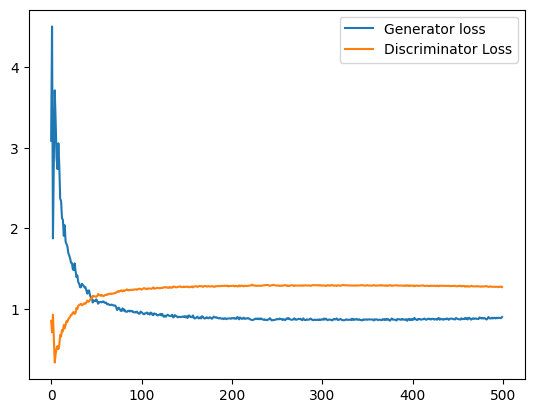

In [20]:
n_epoch = 500
D_losses_f, G_losses_f = [], []
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total = 600):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    D_losses_f.append(torch.mean(torch.FloatTensor(D_losses)))
    G_losses_f.append(torch.mean(torch.FloatTensor(G_losses)))
    
    with torch.no_grad():
        test_z = Variable(torch.randn(64, z_dim).to(device))
        generated = G(test_z)

        save_image(generated.view(generated.size(0), 1, 28, 28), f'./samples2/sample{epoch}' + '.png')
    
plt.figure()
plt.plot(G_losses_f, label='Generator loss')
plt.plot(D_losses_f, label='Discriminator Loss')
plt.legend()
plt.show()

In [1]:
fid_values = [] #
is_values = [] #

with torch.no_grad():
    for i in range(100):
        test_z = Variable(torch.randn(1, z_dim).to(device))
        generated = G(test_z)

        save_image(generated.view(generated.size(0), 1, 28, 28), f"sample0/results{i}.png")

NameError: name 'torch' is not defined

In [22]:
import pickle
with open('./model/G300.pickle','wb')as f: #python路径要用反斜杠
    pickle.dump(G,f) #将模型dump进f里面

FileNotFoundError: [Errno 2] No such file or directory: './model/G300.pickle'